In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing necessary libraries and packages**


In [2]:
#imports
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# **Importing Dataset**

In [3]:
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data',download=True, train=False, transform=ToTensor())


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# **Describing Dataset**

In [4]:
dataset_size =len(dataset)
print("size of dataset: ",dataset_size)

size of dataset:  60000


In [5]:
test_dataset_size = len(test_dataset)
print("size of test data: ",test_dataset_size)

size of test data:  10000


In [6]:
classes = dataset.classes
print("classes in the dataset: ")
classes

classes in the dataset: 


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
num_classes = len(dataset.classes)
print("number of classes: ",num_classes)

number of classes:  10


In [8]:
img, label = dataset[0]
img_shape = img.shape
print("shape of image: ",img_shape)

shape of image:  torch.Size([1, 28, 28])


# Defining Batch Size

In [9]:
batch_size=128

# Defining training and validation data size

In [10]:
torch.manual_seed(43)
val_size = 12000
train_size = len(dataset) - val_size

In [11]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

# Defining Data Loaders

In [12]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

# Visualizing training data

images.shape: torch.Size([128, 1, 28, 28])


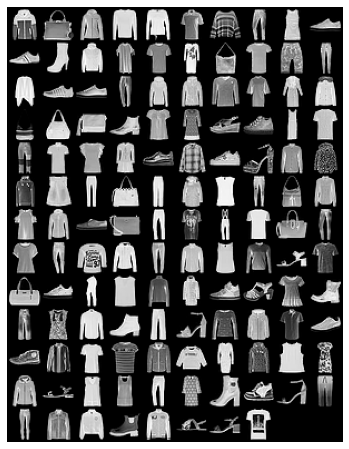

In [13]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    break

# Feed forward neural network

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Training model

In [22]:
input_size = 28*28
output_size = 10

In [23]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [24]:
model = to_device(Model(input_size, output_size), device)

In [25]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3023080825805664, 'val_acc': 0.09995962679386139}]

In [26]:
history += fit(3, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7460, val_acc: 0.5337
Epoch [1], val_loss: 0.9399, val_acc: 0.6280
Epoch [2], val_loss: 0.7765, val_acc: 0.7046


In [30]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3127, val_acc: 0.8947
Epoch [1], val_loss: 0.3134, val_acc: 0.8936
Epoch [2], val_loss: 0.3477, val_acc: 0.8916
Epoch [3], val_loss: 0.3040, val_acc: 0.9044
Epoch [4], val_loss: 0.3028, val_acc: 0.9045


# Evaluating model

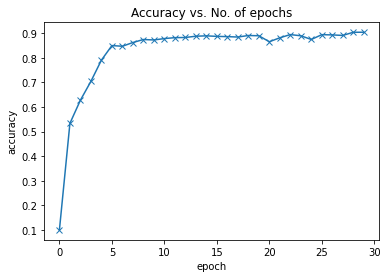

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

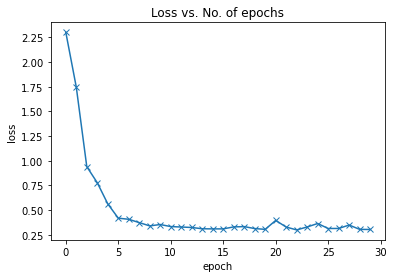

In [32]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

# Evaluate model on test data

In [33]:
evaluate(model, test_loader)

{'val_loss': 0.3179953694343567, 'val_acc': 0.898242175579071}

In [34]:
!pip install jovian --upgrade --quiet

In [35]:
import jovian


<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project="fashion_mnist_project2", environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/imakshit/fashion_mnist_project2


<IPython.core.display.Javascript object>